# 导入相关库

In [102]:
import numpy as np  # 用于进行矩阵计算
import pandas as pd
import matplotlib.pyplot as plt
import cv2  # 用于图片处理
import os
import random
from collections import Counter 
from tqdm import tqdm#输出进度条
from queue import deque
from colorama import Fore
from sklearn.metrics import roc_curve,auc
from cvxopt import matrix,solvers #二次型求解

# 图像处理
## LBP

In [103]:
#各种二进制序列的对应表
uniform_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5, 7: 6, 8: 7, 12: 8,14: 9, 15: 10, 16: 11, 24: 12, 28: 13, 30: 14, 31: 15, 32: 16, 48: 17,
 56: 18, 60: 19, 62: 20, 63: 21, 64: 22, 96: 23, 112: 24,120: 25, 124: 26, 126: 27, 127: 28, 128: 29, 129: 30, 131: 31, 135: 32,143: 33,
 159: 34, 191: 35, 192: 36, 193: 37, 195: 38, 199: 39, 207: 40,223: 41, 224: 42, 225: 43, 227: 44, 231: 45, 239: 46, 240: 47, 241: 48,
243: 49, 247: 50, 248: 51, 249: 52, 251: 53, 252: 54, 253: 55, 254: 56,255: 57}

In [104]:
'''LBP_uniform模型，用于提取图片特征'''
class LBP_uniform:
    def __init__(self):
        #最终存储数据的列表
        self.cell_lbp=[]

    #获取一个列表中各个数字出现的频率
    def get_count(self,LIST):
        #获取一个列表中各个数字出现的频率
        count = Counter(LIST)
        #获取一个长度为59的整数序列
        a=np.arange(59)
        #将其转化为字典的形式
        count_dict = dict(count)
        def check(x):
            if(x in count_dict.keys()):
                return(count_dict[x])
            else:
                return(0)
        #转化为列表输出
        return (list(map(check,a)))
    #在样本点周围8个方向取样，返回一个二进制序列
    def cal_basic_lbp(self,img,i,j):
        sum = []
        if img[i - 1, j ] > img[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        if img[i - 1, j+1 ] > img[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        if img[i , j + 1] > img[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        if img[i + 1, j+1 ] > img[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        if img[i + 1, j ] > img[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        if img[i + 1, j - 1] > img[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        if img[i , j - 1] > img[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        if img[i - 1, j - 1] > img[i, j]:
            sum.append(1)
        else:
            sum.append(0)
        return sum    
    #输入一个cell，返回该cell中所有图样出现的频次
    def fit(self,img): 
        self.cell_lbp=[]
        for i in range(1,img.shape[0]-1):
            for j in range(1,img.shape[1]-1):
                #对非边缘的每一个像素点获得二进制序列
                binary = self.cal_basic_lbp(img,i,j)
                #获得二进制数中跳变次数
                change=0
                for k in range(len(binary)-1):
                    if(binary[k]!=binary[k+1]):
                        change+=1   
                #如果跳变次数小于2则转化为十进制，根据对应表返回相应的序号值            
                if change <= 2:
                    dec = 0#储存计算出的十进制数
                    bit_num = 0 #左移位数
                    for x in binary[::-1]:#从低位读向高位
                        dec += x << bit_num   # 左移n位相当于乘以2的n次方
                        bit_num += 1
                    self.cell_lbp.append(uniform_map[dec])
                #如果跳变次数大于2则返回58
                else:
                    self.cell_lbp.append(58)
        cell_list=self.get_count(self.cell_lbp)    
        return cell_list

## 降维

In [105]:
'''主成分分析，用于给数据降维'''
class PCA:
    def __init__(self,n_component):
        self.n_component=n_component#压缩后的维数
        self.V_cut=None#分解出的正交矩阵
    
    def fit(self,X):
        #普通SVD分解
        U,sigma,V=np.linalg.svd(X)
        #根据输入的n截取正交矩阵V
        self.V_cut=V[0:self.n_component,:]
        return np.dot(X,self.V_cut.T)
    
    #利用从训练集得出的转化矩阵转化测试集和验证集，保证转化方式相同
    def transform(self,X):
        return np.dot(X,self.V_cut.T)

## 功能函数

In [106]:
'''用于对数据进行标准化处理'''
def Std(X):
    #计算均值
    X_mean = X.mean(axis=0)  
    # 计算标准差
    X_std = X.std(axis=0)  
    # 标准化  
    X1 = (X-X_mean)/X_std 
    return (X1)

'''用于对图片预处理后再输入到模型中'''
def img_preprocess(img,lbp):
    img_pro=[]#储存该图片每个cell中各个样式出现的频次
    img = img[128:384, 128:384]  # 裁剪图片为98*98，便于裁剪为小块
    a=8#每行/列cell个数
    width=int(img.shape[0]/a)
    for row in range(a):
        for col in range(a):
            img_cell=img[row*width:(row+1)*width,col*width:(col+1)*width]#裁剪cell
            img_pro.append(lbp.fit(img_cell))
    img_pro=np.array(img_pro)
    return img_pro

'''用于根据预测出的结果和标签计算正确率和混淆矩阵'''
def Accuracy(y_true,y_pred):
    TP,FN,FP,TN = 0,0,0,0#分别记录模型预测的结果中的真正，假负，假正，真负类
    for i in range(len(y_pred)):
        if (y_true[i] == 1):
            if (y_pred[i] == 1):
                TP += 1
            elif (y_pred[i] == 0):
                FN +=1
        elif (y_true[i] == 0):
            if (y_pred[i] == 1):
                FP += 1
            elif (y_pred[i] == 0):
                TN +=1
    confusion_matrix=np.mat([[TP,FP],[FN,TN]])#计算预测结果的混淆矩阵
    Accuracy = (TP+TN)/(TP+TN+FN+FP)
    Recall=TP/(FN+TP)
    Precision=TP/(TP+FP)
    Specificity=TN/(TN+FP)
    F1_score = (2*Precision*Recall)/(Precision+Recall)
    print("Confusion Matrix:\n",confusion_matrix)
    print("Accuracy=",Accuracy)
    print("Recall=",Recall)
    print("Precision=",Precision)
    print("Specificity=",Specificity)
    print("F1_score=",F1_score)
    return Accuracy

In [107]:
'''ROC'''
def ROCplot(y_true,y_pred):
    fpr,tpr,threshold = roc_curve(y_true, y_pred)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print("auc :",roc_auc)

# 读取训练数据

In [108]:
'''加载训练数据'''
print('Loading data...')
num_total = 0  # 总图片数
image = []  # 用于记录图片矩阵的列表
label = []  # 用于记录标签的列表

lbp=LBP_uniform()

content = os.listdir('afhq/train/cat/') # 取cat图片
pbar=tqdm(range(len(content)),bar_format='{l_bar}%s{bar}%s{r_bar}' % (Fore.BLUE, Fore.RESET))#设置进度条
for t in pbar:
    label.append(1)  # 标签记为1
    img = cv2.imread('afhq/train/cat/' + content[t], cv2.IMREAD_GRAYSCALE)
    image.append(img_preprocess(img,lbp))  # 读入处理后的灰度图片
    num_total += 1
    pbar.set_description("cat data")
pbar.close()


  0%|          | 0/5153 [00:00<?, ?it/s]

Loading data...


cat data: 100%|██████████| 5153/5153 [19:13<00:00,  4.47it/s]


In [109]:
content = os.listdir('afhq/train/dog/')  # 取dog图片
pbar=tqdm(range(len(content)),bar_format='{l_bar}%s{bar}%s{r_bar}' % (Fore.BLUE, Fore.RESET))#设置进度条
for t in pbar:
    label.append(0)  # 标签记为0
    img = cv2.imread('afhq/train/dog/' + content[t], cv2.IMREAD_GRAYSCALE)
    image.append(img_preprocess(img,lbp))  # 读入处理后的灰度图片
    num_total += 1
    pbar.set_description("dog data")
pbar.close()


dog data: 100%|██████████| 4739/4739 [17:45<00:00,  4.45it/s]


In [110]:
'''加载测试数据'''
image_test = []  # 用于记录图片矩阵的列表
label_test = []  # 用于记录标签的列表
content = os.listdir('afhq/val/cat/') # 取cat图片
pbar=tqdm(range(len(content)),bar_format='{l_bar}%s{bar}%s{r_bar}' % (Fore.BLUE, Fore.RESET))#设置进度条
for t in pbar:
    label_test.append(1)  # 标签记为1
    img = cv2.imread('afhq/val/cat/' + content[t], cv2.IMREAD_GRAYSCALE)
    image_test.append(img_preprocess(img,lbp))  # 读入处理后的灰度图片
    pbar.set_description("cat data")
pbar.close()

cat data: 100%|██████████| 500/500 [01:51<00:00,  4.47it/s]


In [111]:
content = os.listdir('afhq/val/dog/')  # 取dog图片
pbar=tqdm(range(len(content)),bar_format='{l_bar}%s{bar}%s{r_bar}' % (Fore.BLUE, Fore.RESET))#设置进度条
for t in pbar:
    label_test.append(0)  # 标签记为0
    img = cv2.imread('afhq/val/dog/' + content[t], cv2.IMREAD_GRAYSCALE)
    image_test.append(img_preprocess(img,lbp))  # 读入处理后的灰度图片
    pbar.set_description("dog data")
pbar.close()

dog data: 100%|██████████| 500/500 [01:52<00:00,  4.44it/s]


# Logistic

In [112]:
'''逻辑回归模型，用于最后的输出'''
class LogisticRegression:
    def __init__(self, lr=1e-3, tol=None):
        self.iter_max=2000#最大迭代次数
        self.lr = lr#学习率
        self.tol = tol#误差阈值
        self.w = None#初始化权值向量

    #预测单个实例
    def pred(self, X, w):
        z = np.dot(X,w)#获得线性函数的输出值
        return (1. / (1. + np.exp(-z)))#用sigmoid函数作为输出

    def X_expand(self, X):
        #在X后添加一列并置1，便于和偏置b相乘
        X_expand = np.empty((X.shape[0], X.shape[1] + 1))
        X_expand[:, 0:X.shape[1]] = X
        X_expand[:, X.shape[1]] = 1
        return X_expand

    def train(self, X_train, y_train):
        '''训练'''
        # 预处理X_train(添加x0=1，用于与偏置b相乘)
        X_train = self.X_expand(X_train)  
        # 随机初始化w，便于快速收敛
        self.w = np.random.random(X_train.shape[1])
        # 初始化损失值为正无穷
        loss_old = np.inf

        # 使用梯度下降更新w
        for step in range(self.iter_max):
            # 预测
            y_pred = self.pred(X_train, self.w)
            # 计算损失
            p = y_pred * (2 * y_train - 1) + (1 - y_train)
            loss= -np.sum(np.log(p)) / y_train.size
            # 如果损失下降不足阈值, 则终止迭代
            if loss_old - loss < self.tol:
                break
            #更新损失
            loss_old = loss
            # 计算梯度
            grad=np.matmul(y_pred - y_train, X_train) / y_train.size
            # 向梯度的反方向更新参数w
            self.w -= self.lr * grad

    def predict(self, X):
        '''预测'''
        # 预处理X_test(添加x0=1)
        X = self.X_expand(X)  
        # 预测
        y_pred = self.pred(X, self.w)
    
        return y_pred

In [113]:
#随机打乱训练集
np.random.seed(2020111142)
y = np.array(label)  # y表示标签集
X = np.array(image)  # X表示数据集
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])#展平X中的矩阵
Index = np.arange(num_total)#获取序列
np.random.shuffle(Index)#随机打乱索引
X = X[Index]#打乱数据集
y = y[Index]#打乱标签集

In [114]:
#分割训练集、验证集
train_percent=0.7
X_train=X[0:int(num_total * train_percent),]
X_verify=X[int(num_total * train_percent):num_total,]
y_train = y[0:int(num_total * train_percent)]
y_verify = y[int(num_total * train_percent):num_total]

In [115]:
#PCA降维
pca=PCA(n_component=100)#降至100维
X_train_PCA = pca.fit(X_train)#利用训练集获得转化矩阵
X_verify_PCA = pca.transform(X_verify)
#数据标准化
X_train_PCA_std = Std(X_train_PCA)
X_verify_PCA_std = Std(X_verify_PCA)

In [116]:
'''训练'''
print("Start training:")
best_lg=None
best_acc=0
#超参数列表
LR=[1,0.5,0.1]
TOL=[0.001,0.0001]
#循环选择最优超参数
for Lr in LR:
    for Tol in TOL:
        lg = LogisticRegression(lr=Lr, tol=Tol)#创建逻辑回归模型
        lg.train(X_train_PCA_std, y_train)#读取数据进行训练
        y_pred_verify = lg.predict(X_verify_PCA_std)#利用模型预测验证集中的结果
        y_pred_verify = np.where(y_pred_verify >= 0.5, 1, 0)
        acc_verify=Accuracy(y_pred_verify,y_verify)
        if acc_verify>best_acc:
            best_Lr=Lr
            best_Tol=Tol
            best_acc=acc_verify
print("最优学习率：",best_Lr)
print("最优误差阈值",best_Tol)

Start training:
Confusion Matrix:
 [[1493   41]
 [  50 1384]]
Accuracy= 0.9693396226415094
Recall= 0.9675955930006481
Precision= 0.9732724902216427
Specificity= 0.9712280701754386
F1_score= 0.9704257393565161
Confusion Matrix:
 [[1493   41]
 [  41 1393]]
Accuracy= 0.9723719676549866
Recall= 0.9732724902216427
Precision= 0.9732724902216427
Specificity= 0.9714086471408647
F1_score= 0.9732724902216427


<ipython-input-112-eba357d36410>:36: RuntimeWarning: divide by zero encountered in log
  loss= -np.sum(np.log(p)) / y_train.size
<ipython-input-112-eba357d36410>:38: RuntimeWarning: invalid value encountered in double_scalars
  if loss_old - loss < self.tol:


Confusion Matrix:
 [[1484   50]
 [  51 1383]]
Accuracy= 0.9659703504043127
Recall= 0.9667752442996743
Precision= 0.9674054758800521
Specificity= 0.9651081646894627
F1_score= 0.967090257412838
Confusion Matrix:
 [[1490   44]
 [  41 1393]]
Accuracy= 0.9713611859838275
Recall= 0.9732201175702155
Precision= 0.9713168187744459
Specificity= 0.9693806541405706
F1_score= 0.9722675367047308
Confusion Matrix:
 [[1447   87]
 [  90 1344]]
Accuracy= 0.9403638814016172
Recall= 0.9414443721535458
Precision= 0.9432855280312907
Specificity= 0.939203354297694
F1_score= 0.9423640507977857
Confusion Matrix:
 [[1487   47]
 [  48 1386]]
Accuracy= 0.9679919137466307
Recall= 0.968729641693811
Precision= 0.969361147327249
Specificity= 0.9672016748080949
F1_score= 0.9690452916259368
最优学习率： 1
最优误差阈值 0.0001


In [117]:
#测试集
np.random.seed(2020111142)
y_test=np.array(label_test)
X_test=np.array(image_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
Index_test = np.arange(1000)#获取序列
np.random.shuffle(Index_test)#随机打乱索引
X_test = X_test[Index_test]#打乱数据集
y_test = y_test[Index_test]#打乱标签集

In [118]:
#PCA降维
pca=PCA(n_component=100)#降至100维
X_PCA = pca.fit(X)#利用训练集获得转化矩阵
X_test_PCA = pca.transform(X_test)

#数据标准化
X_PCA_std = Std(X_PCA)
X_test_PCA_std = Std(X_test_PCA)

In [119]:
'''测试集测试'''
lg_test = LogisticRegression(lr=best_Lr, tol=best_Tol)#创建逻辑回归模型
lg_test.train(X_PCA_std, y)#读取数据进行训练
y_pred = lg_test.predict(X_test_PCA_std)#利用模型预测结果
y_pre = np.where(y_pred >= 0.5, 1, 0)

<ipython-input-112-eba357d36410>:36: RuntimeWarning: divide by zero encountered in log
  loss= -np.sum(np.log(p)) / y_train.size
<ipython-input-112-eba357d36410>:38: RuntimeWarning: invalid value encountered in double_scalars
  if loss_old - loss < self.tol:


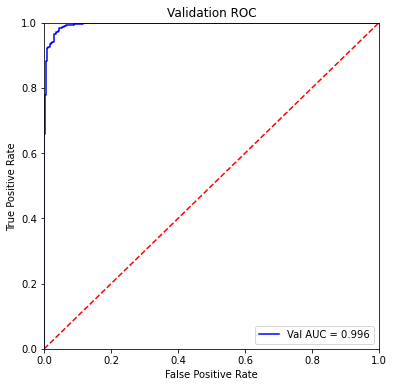

auc : 0.9959279999999999
Confusion Matrix:
 [[491  22]
 [  9 478]]
Accuracy= 0.969
Recall= 0.982
Precision= 0.9571150097465887
Specificity= 0.956
F1_score= 0.9693978282329715


In [120]:
ROCplot(y_test,y_pred)
acc=Accuracy(y_test,y_pre)

# KNN

In [121]:
class KDTree:
    def __init__(self, k_neighbors=5):
        self.k_neighbors = k_neighbors  # 保存最近邻居数k

    def node_depth(self, i):  # 计算节点深度
        deep = np.log2(i + 1)  # 二叉树深度为log2（总节点数+1）
        if ((deep % 1) == 0):  # 若t是整数则直接返回t
            return int(deep)
        else:  # 若t不是整数则向上取整
            return int(deep)+1

    def sort(self, min_distance):  # 将距离降序排列
        for i in range(self.k_neighbors):
            Cur = i
            for j in range(i+1, self.k_neighbors):
                if (min_distance[j][0] > min_distance[Cur][0]):
                    Cur = j
            if (Cur != i):
                temp = min_distance[Cur]
                min_distance[Cur] = min_distance[i]
                min_distance[i] = temp

    def kd_tree_build(self, X):  # 构造KD-Tree
        m, n = X.shape
        tree_depth = self.node_depth(m)  # 计算此时树的深度
        M = 2 ** tree_depth - 1  # 计算填满整棵树后的总节点数
        tree = np.zeros((M, 2), dtype=np.int)  # 每个节点存储一个元组: [0]实例索引, [1]切分特征索引
        tree[:, 0] = -1  # 先将所有的实例索引设置为-1，便于后期检测该节点是否是空节点
        # 创建KD-Tree
        indices = np.arange(m)  # 用总样本数创建一个有序序列
        queue = deque([[0, 0, indices]])  # 以第0个节点的第0个特征开始构建树
        while queue:  # 每次操作清空queue，如果最后queue是空的说明已经构建完毕
            # 记录树节点索引, 切分特征索引和当前区域所有实例索引
            i, feature, indices = queue.popleft()
            mid = indices.size // 2  # 取第l个特征的中位数作为切分点
            feature_order = np.argpartition(
                X[indices, feature], mid)  # 得到将X按第feature个特征排列的索引序列
            indices = indices[feature_order]  # 按第feature个特征重排indices
            tree[i, 0] = indices[mid]  # 树的每个节点第一个值为实例索引
            tree[i, 1] = feature  # 第二个值为切分特征索引
            # 若深度大于特征数，则循环使用下一特征作为切分特征
            feature = (feature + 1) % n
            # 分别将切分点左右区域的节点划分到左右子树
            li, ri = 2 * i + 1, 2 * i + 2
            if indices.size > 1:  # 若还有剩余
                queue.append([li, feature, indices[:mid]])  # 将小于部分归到左子树
            if indices.size > 2:  # 若还有多个剩余
                queue.append([ri, feature, indices[mid+1:]])  # 将大于部分归到右子树
        return tree, tree_depth  # 返回树和树的深度

    def kd_tree_search(self, x, root, X, min_distance):  # 搜索KD-Tree, 将最近的k个邻居放入大端堆
        idx = self.tree[root, 0]  # 获取根节点的索引
        if idx < 0:  # 判断根节点是否是空节点, 若是则停止搜索直接返回
            return
        root_depth = self.node_depth(root)  # 获取当前根节点深度
        i = root  # 移动到x所在最小超矩形区域相应的叶节点
        for _ in range(self.tree_depth - root_depth-1):  # 循环直到进入到某个叶子节点
            node = X[idx]
            l = self.tree[i, 1]  # 获取当前节点切分特征索引
            if x[l] <= node[l]:  # 根据当前节点切分特征的值, 将输入实例选择移动到左儿子或右儿子节点
                i = i * 2 + 1  # 如果小则移动到左子树寻找
            else:
                i = i * 2 + 2  # 如果大则移动到右子树寻找
            idx = self.tree[i, 0]  # 获取下一层节点的索引值
        if idx > 0:
            leaf = X[idx]
            distance = np.linalg.norm(x - leaf)  # 计算到叶节点中实例的距离
            # 进行入堆出堆操作, 更新当前k个最近邻居和最近距离
            if distance < min_distance[0][0]:
                min_distance[0] = (distance, idx)
                self.sort(min_distance)
        while i > root:  # 从叶子节点回退，直到根节点停止搜索
            # 计算到父节点中实例的距离, 并更新当前最近距离
            parent_i = (i - 1) // 2  # 回退到父节点
            parent_idx = self.tree[parent_i, 0]  # 获取父节点的索引
            parent = X[parent_idx]  # 获取父节点存储的实例
            distance = np.linalg.norm(x - parent)  # 计算父节点和输入实例的距离
            # 进行入堆出堆操作, 更新当前k个最近邻居和最近距离
            if distance < min_distance[0][0]:
                min_distance[0] = (distance, parent_idx)
                self.sort(min_distance)
            # 获取父节点切分特征索引，判断是否要在另一棵子树中继续搜索
            l = self.tree[parent_i, 1]
            radius = min_distance[0][0]  # 获取目前超球体半径
            # 判断超球体(x, r)是否与兄弟节点区域相交
            if np.abs(x[l] - parent[l]) < radius:  # 若相交
                # 获取兄弟节点的树索引
                if(i % 2 == 0):  # 若i是偶数说明叶子节点位于右子树，兄弟节点在左子树
                    brother_i = i-1
                else:
                    brother_i = i+1
                # 递归搜索兄弟子树
                self.kd_tree_search(x, brother_i, X, min_distance)
            i = parent_i  # 向根节点回退

    def train(self, X_train, y_train):  # 训练
        # 保存训练集
        self.X_train = X_train
        self.y_train = y_train

        self.tree, self.tree_depth = self.kd_tree_build(
            X_train)  # 构造k-d树, 保存树及树的深度

    def predict_one(self, x):  # 对单个实例进行预测
        # 创建存储k个最近邻居索引的最大堆
        min_distance = []
        for i in range(self.k_neighbors):
            min_distance.append((np.inf, -1))
        # 从根开始搜索kd tree, 将最近的k个邻居将存入堆
        self.kd_tree_search(x, 0, self.X_train, min_distance)
        # 获取k个邻居的索引
        #根据k个邻居中0或1出现次数决定输入实例的判断结果
        num_zero = 0
        for i in range(self.k_neighbors):
            if self.y_train[min_distance[i][1]] == 0:
                num_zero += 1
            else:
                num_zero += 0
        if num_zero > (self.k_neighbors-1)/2:
            return 0
        else:
            return 1

    def predict(self, X):  # 预测
        y_pred = []
        for i in range(X.shape[0]):
            print(i, '/', X.shape[0])
            # 对X中每个实例依次调用predict_one方法进行预测
            y_pred.append(self.predict_one(X[i]))
        return(y_pred)

In [122]:
#随机打乱训练集
y = np.array(label)  # y表示标签集
X = np.array(image)  # X表示数据集
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])#展平X中的矩阵
Index = np.arange(num_total)#获取序列
np.random.shuffle(Index)#随机打乱索引
X = X[Index]#打乱数据集
y = y[Index]#打乱标签集

In [123]:
#分割训练集、验证集
train_percent=0.7
X_train=X[0:int(num_total * train_percent),]
X_verify=X[int(num_total * train_percent):num_total,]
y_train = y[0:int(num_total * train_percent)]
y_verify = y[int(num_total * train_percent):num_total]

In [124]:
#PCA降维
pca=PCA(n_component=100)#降至100维
X_train_PCA = pca.fit(X_train)#利用训练集获得转化矩阵
X_verify_PCA = pca.transform(X_verify)
#数据标准化
X_train_PCA_std = Std(X_train_PCA)
X_verify_PCA_std = Std(X_verify_PCA)

In [125]:
best_acc = 0
accuracy = []
for k in range(1,21):
    knn = KDTree(k_neighbors=k)
    knn.train(X_train_PCA_std, y_train)
    y_pred = knn.predict(X_verify_PCA_std)
    err = 0
    for i in range(len(y_pred)):
        if(y_pred[i] != y_verify[i]):
            err += 1
    acc = 1-err/len(y_pred)
    accuracy.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_k = k

<ipython-input-121-d9eac476c277>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tree = np.zeros((M, 2), dtype=np.int)  # 每个节点存储一个元组: [0]实例索引, [1]切分特征索引


0 / 2968
1 / 2968
2 / 2968
3 / 2968
4 / 2968
5 / 2968
6 / 2968
7 / 2968
8 / 2968
9 / 2968
10 / 2968
11 / 2968
12 / 2968
13 / 2968
14 / 2968
15 / 2968
16 / 2968
17 / 2968
18 / 2968
19 / 2968
20 / 2968
21 / 2968
22 / 2968
23 / 2968
24 / 2968
25 / 2968
26 / 2968
27 / 2968
28 / 2968
29 / 2968
30 / 2968
31 / 2968
32 / 2968
33 / 2968
34 / 2968
35 / 2968
36 / 2968
37 / 2968
38 / 2968
39 / 2968
40 / 2968
41 / 2968
42 / 2968
43 / 2968
44 / 2968
45 / 2968
46 / 2968
47 / 2968
48 / 2968
49 / 2968
50 / 2968
51 / 2968
52 / 2968
53 / 2968
54 / 2968
55 / 2968
56 / 2968
57 / 2968
58 / 2968
59 / 2968
60 / 2968
61 / 2968
62 / 2968
63 / 2968
64 / 2968
65 / 2968
66 / 2968
67 / 2968
68 / 2968
69 / 2968
70 / 2968
71 / 2968
72 / 2968
73 / 2968
74 / 2968
75 / 2968
76 / 2968
77 / 2968
78 / 2968
79 / 2968
80 / 2968
81 / 2968
82 / 2968
83 / 2968
84 / 2968
85 / 2968
86 / 2968
87 / 2968
88 / 2968
89 / 2968
90 / 2968
91 / 2968
92 / 2968
93 / 2968
94 / 2968
95 / 2968
96 / 2968
97 / 2968
98 / 2968
99 / 2968
100 / 2968

6


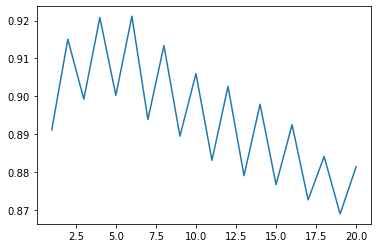

In [126]:
print(best_k)
plt.plot(range(1,21),accuracy)

In [127]:
#测试集
y_test=np.array(label_test)
X_test=np.array(image_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
Index_test = np.arange(1000)#获取序列
np.random.shuffle(Index_test)#随机打乱索引
X_test = X_test[Index_test]#打乱数据集
y_test = y_test[Index_test]#打乱标签集

In [128]:
#PCA降维
pca=PCA(n_component=100)#降至100维
X_PCA = pca.fit(X)#利用训练集获得转化矩阵
X_test_PCA = pca.transform(X_test)

#数据标准化
X_PCA_std = Std(X_PCA)
X_test_PCA_std = Std(X_test_PCA)

In [129]:
knn_test = KDTree(k_neighbors=best_k)
knn_test.train(X_PCA, y)
y_pred = knn_test.predict(X_test_PCA)#利用模型预测结果

<ipython-input-121-d9eac476c277>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tree = np.zeros((M, 2), dtype=np.int)  # 每个节点存储一个元组: [0]实例索引, [1]切分特征索引


0 / 1000
1 / 1000
2 / 1000
3 / 1000
4 / 1000
5 / 1000
6 / 1000
7 / 1000
8 / 1000
9 / 1000
10 / 1000
11 / 1000
12 / 1000
13 / 1000
14 / 1000
15 / 1000
16 / 1000
17 / 1000
18 / 1000
19 / 1000
20 / 1000
21 / 1000
22 / 1000
23 / 1000
24 / 1000
25 / 1000
26 / 1000
27 / 1000
28 / 1000
29 / 1000
30 / 1000
31 / 1000
32 / 1000
33 / 1000
34 / 1000
35 / 1000
36 / 1000
37 / 1000
38 / 1000
39 / 1000
40 / 1000
41 / 1000
42 / 1000
43 / 1000
44 / 1000
45 / 1000
46 / 1000
47 / 1000
48 / 1000
49 / 1000
50 / 1000
51 / 1000
52 / 1000
53 / 1000
54 / 1000
55 / 1000
56 / 1000
57 / 1000
58 / 1000
59 / 1000
60 / 1000
61 / 1000
62 / 1000
63 / 1000
64 / 1000
65 / 1000
66 / 1000
67 / 1000
68 / 1000
69 / 1000
70 / 1000
71 / 1000
72 / 1000
73 / 1000
74 / 1000
75 / 1000
76 / 1000
77 / 1000
78 / 1000
79 / 1000
80 / 1000
81 / 1000
82 / 1000
83 / 1000
84 / 1000
85 / 1000
86 / 1000
87 / 1000
88 / 1000
89 / 1000
90 / 1000
91 / 1000
92 / 1000
93 / 1000
94 / 1000
95 / 1000
96 / 1000
97 / 1000
98 / 1000
99 / 1000
100 / 1000

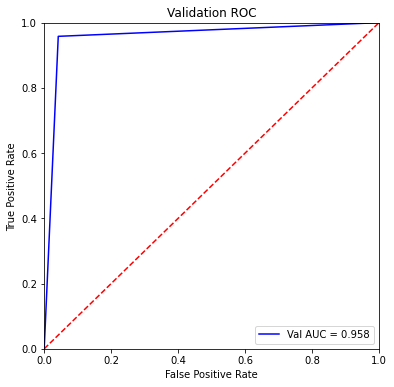

auc : 0.958
Confusion Matrix:
 [[479  21]
 [ 21 479]]
Accuracy= 0.958
Recall= 0.958
Precision= 0.958
Specificity= 0.958
F1_score= 0.958


In [130]:
ROCplot(y_test,y_pred)
acc=Accuracy(y_test,y_pred)

# SVM 对偶优化

In [131]:
y = np.array(label)  # y表示标签集
X = np.array(image)  # X表示数据集
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])#展平X中的矩阵
y[y==1]=-1
y[y==0]=1
print(X.shape)
length=int(len(X)/10)
print("verifysize:",length)
print("trainsize:",len(X)-length)

(9892, 3776)
verifysize: 989
trainsize: 8903


In [132]:
#划分训练集、验证集
random.seed(2020111142)
num=list(range(0,9892))
random.shuffle(num)

verify=np.zeros((10,length))
training=np.zeros((10,8903))
for i in range(1,11):
    for j in range(0,length):
        verify[i-1,j]=num[(i-1)*length+(j)]
for i in range(1,11):
    training[i-1]=np.setdiff1d(num,verify[i-1])

X_train=np.zeros((8903,3776))
X_verify=np.zeros((989,3776))
y_train=np.zeros((8903,1))
y_verify=np.zeros((989,1))

In [133]:
C_list=[0.1,0.5,1,5,10]
ACC=[]
accuracies=[]

#10-fold选取C

for C in C_list:
    for j in range(0,10):
        for i in range(0,8903):   #训练集
            X_train[i] = X[int(training[j,i])]
            y_train[i] = y[int(training[j,i])]
        for i in range(0,989):   #测试集
            X_verify[i] = X[int(verify[j,i])]
            y_verify[i] = y[int(verify[j,i])]
        #PCA降维
        pca=PCA(n_component=100)#降至100维
        X_train_PCA = pca.fit(X_train)#利用训练集获得转化矩阵
        X_verify_PCA = pca.transform(X_verify)
        #数据标准化
        X_train_PCA_std = Std(X_train_PCA)
        X_verify_PCA_std = Std(X_verify_PCA)
        #solvers.qp二次型求解
        P=matrix(np.multiply(y_train@y_train.T,X_train_PCA_std@X_train_PCA_std.T))
        q=matrix(np.ones((8903,1))*(-1))
        G=matrix(np.vstack((np.identity(8903),np.identity(8903)*(-1))))
        h=matrix(np.vstack((np.ones((8903,1))*C,np.zeros((8903,1)))))
        A=matrix(y_train.T)
        b=matrix(0.0)
        sol=solvers.qp(P,q,G,h,A,b)
    
        alpha=np.array(sol['x'])
        beta_t=X_train_PCA_std.T@(alpha*y_train)
        beta_0=(1/y_train)-X_train_PCA_std@beta_t
        #筛选求beta0
        select=alpha.T.tolist()[0]
        index=[]
        for i in range(len(select)):
            if 0.01<select[i]<0.99:
                index.append(i)
        beta0=np.mean(beta_0[index,])
        #预测并计算准确度
        fx=X_verify_PCA_std@beta_t+beta0
        pred=np.sign(y_verify*fx)
        acc=np.sum(pred>0)
        accuracy=acc/989
        accuracies.append(accuracy)
    ACC.append(np.mean(accuracies))

     pcost       dcost       gap    pres   dres
 0: -9.8559e+02 -2.0317e+03  9e+04  3e+01  1e-12
 1: -1.7558e+02 -1.8904e+03  6e+03  2e+00  1e-12
 2: -1.1191e+02 -9.8988e+02  1e+03  3e-01  3e-13
 3: -8.1736e+01 -4.0885e+02  5e+02  1e-01  2e-13
 4: -6.8466e+01 -2.0768e+02  2e+02  4e-02  1e-13
 5: -6.3984e+01 -1.4604e+02  1e+02  2e-02  1e-13
 6: -6.4904e+01 -9.3080e+01  4e+01  5e-03  1e-13
 7: -6.4223e+01 -8.1892e+01  2e+01  1e-03  1e-13
 8: -6.5761e+01 -7.6722e+01  1e+01  7e-04  1e-13
 9: -6.6601e+01 -7.4076e+01  8e+00  3e-04  1e-13
10: -6.7572e+01 -7.2087e+01  5e+00  2e-04  1e-13
11: -6.8212e+01 -7.0855e+01  3e+00  6e-05  1e-13
12: -6.8599e+01 -7.0184e+01  2e+00  2e-05  1e-13
13: -6.8969e+01 -6.9681e+01  7e-01  7e-06  1e-13
14: -6.9102e+01 -6.9502e+01  4e-01  2e-06  1e-13
15: -6.9225e+01 -6.9361e+01  1e-01  6e-07  1e-13
16: -6.9261e+01 -6.9319e+01  6e-02  1e-07  1e-13
17: -6.9282e+01 -6.9296e+01  1e-02  2e-08  1e-13
18: -6.9287e+01 -6.9290e+01  3e-03  3e-09  1e-13
19: -6.9289e+01 -6.92

In [134]:
print("10-fold交叉验证准确度结果为",ACC)
print("最优C值为",C_list[ACC.index(max(ACC))])
print("最优C值对应的准确度为",ACC[ACC.index(max(ACC))])

10-fold交叉验证准确度结果为 [0.9683518705763398, 0.9678968655207282, 0.9677789012470509, 0.967644084934277, 0.9676643073811931]
最优C值为 0.1
最优C值对应的准确度为 0.9683518705763398


In [149]:
'''正式训练和测试'''
y = np.array(label)  # y表示标签集
X = np.array(image)  # X表示数据集
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])#展平X中的矩阵
y[y==1]=-1
y[y==0]=1
y_train=np.zeros((9892,1))
y_true=np.zeros((1000,1))
for i in range(0,9892):
    y_train[i]=y[i]
for i in range(0,1000):
    y_true[i]=y_test[i]
y_true[y_true==1]=-1
y_true[y_true==0]=1

In [150]:
C=C_list[ACC.index(max(ACC))]
#降维
pca=PCA(n_component=100)#降至100维
X_PCA = pca.fit(X)#利用训练集获得转化矩阵
X_test_PCA = pca.transform(X_test)
#数据标准化
X_PCA_std = Std(X_PCA)
X_test_PCA_std = Std(X_test_PCA)

P=matrix(np.multiply(y_train@y_train.T,X_PCA_std@X_PCA_std.T))
q=matrix(np.ones((9892,1))*(-1))
G=matrix(np.vstack((np.identity(9892),np.identity(9892)*(-1))))
h=matrix(np.vstack((np.ones((9892,1))*C,np.zeros((9892,1)))))
A=matrix(y_train.T)
b=matrix(0.0)
sol=solvers.qp(P,q,G,h,A,b)

#求解超平面系数beta_t截距beta0
alpha=np.array(sol['x'])
beta_t=X_PCA_std.T@(alpha*y_train)
beta_0=(1/y_train)-X_PCA_std@beta_t

select=alpha.T.tolist()[0]
index=[]
for i in range(len(select)):
    if 0.01<select[i]<0.99:
        index.append(i)
#beta0=beta_0[index,][0,0]
beta0=np.mean(beta_0[index,])

#计算准确性
fx=X_test_PCA_std@beta_t+beta0
pred=np.sign(y_true*fx)

print("拟合SVM的系数beta为",beta_t)
print("拟合SVM的截距项beta0为",beta0)

     pcost       dcost       gap    pres   dres
 0: -1.0951e+03 -2.2442e+03  1e+05  3e+01  2e-12
 1: -1.9711e+02 -2.0877e+03  7e+03  2e+00  2e-12
 2: -1.2482e+02 -1.1057e+03  2e+03  3e-01  4e-13
 3: -9.1171e+01 -4.5954e+02  6e+02  1e-01  2e-13
 4: -7.6527e+01 -2.5005e+02  3e+02  4e-02  2e-13
 5: -7.1252e+01 -1.5294e+02  1e+02  2e-02  1e-13
 6: -7.0876e+01 -1.1132e+02  5e+01  6e-03  1e-13
 7: -7.2291e+01 -9.2892e+01  3e+01  3e-03  1e-13
 8: -7.3480e+01 -8.4735e+01  1e+01  1e-03  1e-13
 9: -7.4136e+01 -8.1096e+01  8e+00  4e-04  1e-13
10: -7.4827e+01 -7.9031e+01  5e+00  2e-04  1e-13
11: -7.5204e+01 -7.8211e+01  3e+00  1e-04  1e-13
12: -7.5583e+01 -7.7237e+01  2e+00  2e-05  2e-13
13: -7.5940e+01 -7.6792e+01  9e-01  8e-06  1e-13
14: -7.6131e+01 -7.6551e+01  4e-01  2e-06  1e-13
15: -7.6243e+01 -7.6421e+01  2e-01  5e-07  2e-13
16: -7.6292e+01 -7.6367e+01  8e-02  2e-07  1e-13
17: -7.6311e+01 -7.6347e+01  4e-02  6e-08  1e-13
18: -7.6325e+01 -7.6332e+01  7e-03  9e-14  2e-13
19: -7.6328e+01 -7.63

In [146]:
def confusionSVM(y_true, y_pred):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_true)):
        if y_true[i] == -1 and y_pred[i] == 1:
            TP += 1
        if y_true[i] == -1 and y_pred[i] == -1:
            FN += 1
        if y_true[i] == 1 and y_pred[i] == 1:
            TN += 1
        if y_true[i] == 1 and y_pred[i] == -1:
            FP += 1
    confusion_matrix=np.mat([[TP,FP],[FN,TN]])#计算预测结果的混淆矩阵
    Accuracy = (TP+TN)/(TP+TN+FN+FP)
    Recall=TP/(FN+TP)
    Precision=TP/(TP+FP)
    Specificity=TN/(TN+FP)
    F1_score = (2*Precision*Recall)/(Precision+Recall)
    print("Confusion Matrix:\n",confusion_matrix)
    print("Accuracy=",Accuracy)
    print("Recall=",Recall)
    print("Precision=",Precision)
    print("Specificity=",Specificity)
    print("F1_score=",F1_score)


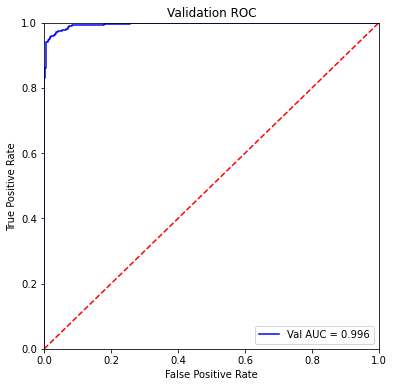

auc : 0.9956320000000001
Confusion Matrix:
 [[492  23]
 [  8 477]]
Accuracy= 0.969
Recall= 0.984
Precision= 0.9553398058252427
Specificity= 0.954
F1_score= 0.9694581280788177


In [151]:
ROCplot(y_true,fx)
confusionSVM(y_true,pred)

# SVM ADMM

In [139]:
y = np.array(label)  # y表示标签集
X = np.array(image)  # X表示数据集
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])#展平X中的矩阵
y[y==1]=-1
y[y==0]=1
print(X.shape)
length=int(len(X)/10)
print("verifysize:",length)
print("trainsize:",len(X)-length)

(9892, 3776)
verifysize: 989
trainsize: 8903


In [140]:
#划分训练集、验证集
random.seed(2020111142)
num=list(range(0,9892))
random.shuffle(num)

verify=np.zeros((10,length))
training=np.zeros((10,8903))
for i in range(1,11):
    for j in range(0,length):
        verify[i-1,j]=num[(i-1)*length+(j)]
for i in range(1,11):
    training[i-1]=np.setdiff1d(num,verify[i-1])

X_train=np.zeros((8903,3776))
X_verify=np.zeros((989,3776))
y_train=np.zeros((8903,1))
y_verify=np.zeros((989,1))

In [141]:
error=np.zeros((10,61))
cv=np.zeros((1,61))
lamda = np.zeros((1,61))

#10-fold选取lambda
for j in range(0,10):
    for i in range(0,8903):   #训练集
        X_train[i] = X[int(training[j,i])]
        y_train[i] = y[int(training[j,i])]
    for i in range(0,989):   #测试集
        X_verify[i] = X[int(verify[j,i])]
        y_verify[i] = y[int(verify[j,i])]
    #PCA降维
    pca=PCA(n_component=100)#降至100维
    X_train_PCA = pca.fit(X_train)#利用训练集获得转化矩阵
    X_verify_PCA = pca.transform(X_verify)
    #标准化
    X_train_PCA_std = Std(X_train_PCA)
    X_verify_PCA_std = Std(X_verify_PCA)

    for s in range(0,61): 
        lamda[0,s] = 10**(-3+0.1*s)
        t = np.linalg.inv((X_train_PCA_std.T)@X_train_PCA_std+lamda[0,s]*np.identity((100)))@X_train_PCA_std.T
        beta_hat = t@y_train
        error[j,s] = (1/989)*np.linalg.norm(y_verify-X_verify_PCA_std@beta_hat,ord=2)\
        *np.linalg.norm(y_verify-X_verify_PCA_std@beta_hat,ord=2)

for i in range(0,61):
    cv[0,i]=np.mean(error[:,i])
s_admm=np.argmin(cv)
lamda_admm=10**(-3+0.1*s_admm)

print("10-fold交叉验证：")
print("Selected s is {}".format(s_admm))
print("Selected lamda is {}".format(lamda_admm))

10-fold交叉验证：
Selected s is 29
Selected lamda is 0.7943282347242822


In [142]:
'''正式训练和测试'''
y = np.array(label)  # y表示标签集
X = np.array(image)  # X表示数据集
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])#展平X中的矩阵
y[y==1]=-1
y[y==0]=1
y_train=np.zeros((9892,1))
y_true=np.zeros((1000,1))
for i in range(0,9892):
    y_train[i]=y[i]
for i in range(0,1000):
    y_true[i]=y_test[i]
y_true[y_true==1]=-1
y_true[y_true==0]=1

In [143]:
#降维
pca=PCA(n_component=100)#降至100维
X_PCA = pca.fit(X)#利用训练集获得转化矩阵
X_test_PCA = pca.transform(X_test)
#数据标准化
X_PCA_std = Std(X_PCA)
X_test_PCA_std = Std(X_test_PCA)

In [144]:
rho=1
Beta1=np.zeros((100,1))
alpha1=np.zeros((9892,1))
kesi1=np.zeros((9892,1))
miu1=np.zeros((9892,1))
#ADMM算法
for i in range(100000):
    Beta0 = Beta1
    alpha0 = alpha1
    kesi0 = kesi1
    miu0=miu1
    Beta1=np.linalg.inv(lamda_admm*np.identity(100)+rho*X_PCA_std.T@X_PCA_std)\
    @(rho*X_PCA_std.T@(y_train*(1-alpha0+kesi0+miu0)))
    alpha1=np.maximum((1-y_train*X_PCA_std@Beta1+miu0-1/(9892*rho)),np.zeros((9892,1)))
    kesi1=np.maximum((-(1-y_train*X_PCA_std@Beta1)-miu0),np.zeros((9892,1)))
    miu1=miu0+1-y_train*X_PCA_std@Beta1-alpha1+kesi1
    if np.linalg.norm(Beta1-Beta0,ord=2)+np.linalg.norm(alpha1-alpha0,ord=2)\
    +np.linalg.norm(kesi1-kesi0,ord=2)+np.linalg.norm(miu1-miu0,ord=2)<0.00001:#收敛准则
        break

beta_res=Beta1
miu_res=miu1

fx=X_test_PCA_std@beta_res
pred=np.sign(y_true*fx)

print("beta结果为",-beta_res)

beta结果为 [[-0.10010873]
 [ 0.07702333]
 [-0.44250831]
 [-0.12752848]
 [ 0.51779858]
 [ 0.00966729]
 [ 0.00199686]
 [-0.01714836]
 [-0.08884277]
 [ 0.00761838]
 [ 0.09581576]
 [ 0.01741428]
 [ 0.06463467]
 [ 0.13321414]
 [ 0.03249831]
 [ 0.03385059]
 [ 0.01304365]
 [ 0.02667644]
 [-0.07132583]
 [-0.02868105]
 [-0.04221091]
 [-0.09205904]
 [ 0.07942671]
 [-0.04613846]
 [ 0.04256547]
 [ 0.00966338]
 [ 0.03339591]
 [-0.00782535]
 [ 0.03095002]
 [-0.04620269]
 [-0.00724971]
 [ 0.00522976]
 [-0.00172651]
 [-0.00644919]
 [-0.03430218]
 [-0.03806115]
 [-0.00610203]
 [-0.01145031]
 [-0.02698649]
 [ 0.02173236]
 [-0.06859717]
 [-0.03027144]
 [ 0.02209883]
 [ 0.02380029]
 [ 0.00224347]
 [-0.02180691]
 [-0.05644741]
 [-0.01868745]
 [-0.01548827]
 [ 0.00438411]
 [-0.01309574]
 [-0.00282454]
 [ 0.01046146]
 [ 0.00486225]
 [ 0.00404661]
 [-0.01242111]
 [-0.02600524]
 [ 0.01914076]
 [ 0.01404071]
 [ 0.00416643]
 [ 0.00445845]
 [ 0.00550629]
 [ 0.00352943]
 [-0.0184043 ]
 [ 0.00751784]
 [ 0.01246356]
 [

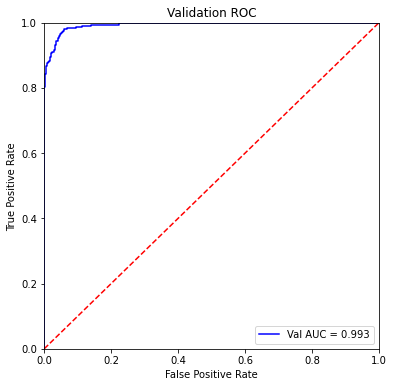

auc : 0.993044
Confusion Matrix:
 [[479  27]
 [ 21 473]]
Accuracy= 0.952
Recall= 0.958
Precision= 0.9466403162055336
Specificity= 0.946
F1_score= 0.9522862823061631


In [148]:
ROCplot(y_true,fx)
confusionSVM(y_true,pred)